In [1]:
from math import log, isnan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import plotly.graph_objects as go
import plotly.express as px
import osmnx as ox
import geopandas as gpd


data = pd.read_excel("datasets/Cleaned_data.xlsx")
# pd.options.display.max_rows = 999

In [2]:
biblio_file = open("datasets/savedrecs.txt", "r")
first_country = []
first_affiliation = []
first_affiliation_coordinates = []
doi = []
for line in biblio_file:
    if line[0:2] == "C1":
        country = line.split(",")[-1][:-2].strip()
        if country.endswith("USA"):
            country = "USA"
        first_country.append(country)
    elif line[0:2] == "C3":
        first_affiliation.append(line.split(";")[0][3:].strip())
        if first_affiliation[-1] == "Southeast University - China":
            first_affiliation_coordinates.append(
                ox.geocode("South east University, China")
            )
        elif first_affiliation[-1] == "Korea Transport Institute":
            first_affiliation_coordinates.append(
                ox.geocode("370 Sicheong-daero, Korea")
            )
        elif first_affiliation[-1] == "RLUK- Research Libraries UK":
            first_affiliation_coordinates.append(
                ox.geocode("Senate House University of London")
            )
        elif first_affiliation[-1] == "N8 Research Partnership":
            first_affiliation_coordinates.append(
                ox.geocode("Alliance Manchester Business School")
            )
        elif first_affiliation[-1] == "Tottori University":
            first_affiliation_coordinates.append(ox.geocode("国立大学法人鳥取大学 鳥取キャンパス"))
        elif (
            first_affiliation[-1] == "Seoul National University of Science & Technology"
        ):
            first_affiliation_coordinates.append(
                ox.geocode("Seoul National University of Science")
            )
        elif (
            first_affiliation[-1]
            == "Korea Institute of Civil Engineering & Building Technology (KICT)"
        ):
            first_affiliation_coordinates.append(
                ox.geocode(
                    "KICT Korean Institute of Civil Engineering and Building Technology"
                )
            )
        elif first_affiliation[-1] == "Rutgers State University New Brunswick":
            first_affiliation_coordinates.append(ox.geocode("Rutgers–New Brunswick"))
        elif first_affiliation[-1] == "Swiss Federal Institutes of Technology Domain":
            first_affiliation_coordinates.append(ox.geocode("ETH Zürich"))
        elif first_affiliation[-1] == "Osaka University":
            first_affiliation_coordinates.append(ox.geocode("Osaka University Japan"))
        elif first_affiliation[-1] == "Korea Railroad Research Institute (KRRI)":
            first_affiliation_coordinates.append(
                ox.geocode("176 Cheoldobangmulgwan-ro, Uiwang-si")
            )
        else:
            first_affiliation_coordinates.append(ox.geocode(first_affiliation[-1]))

    elif line[0:2] == "DI":
        doi.append(line[3:].strip())
first_affiliation.insert(
    doi.index("10.1007/s12469-022-00309-0"), "Ben-Gurion University of the Negev"
)
first_affiliation_coordinates.insert(
    doi.index("10.1007/s12469-022-00309-0"),
    ox.geocode("Ben-Gurion University of the Negev"),
)
first_affiliation.insert(doi.index("10.1017/dce.2020.15"), "Imperial College London")
first_affiliation_coordinates.insert(
    doi.index("10.1017/dce.2020.15"), ox.geocode("Imperial College London")
)
first_affiliation.insert(doi.index("10.1016/j.jtrangeo.2018.02.004"), "TUMCREATE")
first_affiliation_coordinates.insert(
    doi.index("10.1016/j.jtrangeo.2018.02.004"), ox.geocode("Create Singapore")
)
biblio = pd.DataFrame(
    {
        "First country": first_country,
        "First affiliation": first_affiliation,
        "DOI": doi,
        "First affiliation coordinates": first_affiliation_coordinates,
    }
)

In [3]:
# # Specify the name that is used to seach for the data

# # import osmnx


# # Get place boundary related to the place name as a geodataframe
# temp = pd.Series()
# for i, place in enumerate(biblio["First affiliation"].items()):
#     temp[i] = ox.geocode(place)

# biblio = pd.concat([biblio, temp], axis=1)
# biblio

In [4]:
data = pd.merge(data,biblio, how='left', on ='DOI')

In [5]:
# Para limpiar la columna Publication date

def pub_date_clean(column_date, column_year):
    temp = pd.Series()
    for i, row in enumerate(column_date):
        if row is np.NaN:
            temp[i] = str(column_year[i])
        elif row[0] in "0123456789":
            temp_df = row.split(" ")
            temp[i] = temp_df[2] + "/" + temp_df[1] + "/" + temp_df[0]
        elif row[-1] in "0123456789":
            temp_df = row.split(" ")
            temp[i] = temp_df[1] + "/" + temp_df[0] + "/" + str(column_year[i])
        else:
            temp[i] = "01/" + row + "/" + str(column_year[i])
    return pd.to_datetime(temp)

In [6]:
# Para limpiar la columna Year(s)

def years_clean(column_years):
    temp = pd.Series()
    for i, row in enumerate(column_years):
        if row is np.NaN:
            temp[i] = []
        elif ';' in row:
            temp_df = row.split(";")
            temp[i] = [int(elem) for elem in temp_df]
        elif '-' in row:
            temp_df = row.split("-")
            temp[i] = list(range(int(temp_df[0]), int(temp_df[1])+1))
        else:
            temp[i] = [int(row)]
    return temp

In [7]:
# Para limpiar la columna Total number transactions

def logarithmic_range(column):
    temp = pd.Series()
    for i, row in enumerate(column):
        if isnan(row):
            temp[i] = "NA"
        elif log(row, 10) == int(log(row, 10)):
            temp[i] = (
                "(" + str(int(log(row, 10)) - 1) + ", " + str(int(log(row, 10))) + "]"
            )
        else:
            temp[i] = (
                "(" + str(int(log(row, 10))) + ", " + str(int(log(row, 10)) + 1) + "]"
            )
    return temp

In [8]:
# Para limpiar la columna Days

def days_range(column):
    temp = pd.Series()
    for i, row in enumerate(column):
        if isnan(row):
            temp[i] = "NA"
        elif row < 14:
            temp[i] = "Days"
        elif row < 31:
            temp[i] = "Weeks"
        elif row < 365:
            temp[i] = "Months"
        else:
            temp[i] = "Year(s)"
    return temp

In [9]:
# Para pasar de un array por comas a una lista

def comma_array_to_list(column):
    return (
        column.str.split(";")
        .apply(lambda x: (list() if isinstance(x, float) else list(x)))
        .apply(lambda x: list(map(str.strip, x)))
    )

In [10]:
# Crea un set a partir de las listas de las columnas, facilita crear una lista de elementos sin repetir aquellos que son iguales

def set_column_uninon(column):
    return set.union(*column.apply(lambda x: set(x)).tolist())

In [11]:
# Cuenta las ocurrencias de cada elemento de un set

def count_set_occurences(column):
    union_set = set_column_uninon(column)
    occurence_count_dict = dict.fromkeys(union_set, 0)
    for row in column:
        for elem in row:
            occurence_count_dict[elem] += 1
    return occurence_count_dict

In [12]:
# Cuenta las ocurrencias de cada elemento de un set agrupado por otra columna, por ejemplo la de Publication Year

def count_set_occurences_by(data_column, by_column):
    union_set_data = set_column_uninon(data_column)
    union_set_by = set(by_column.tolist())
    occurence_count_dict = dict.fromkeys(union_set_data, 0)
    for elem in occurence_count_dict.keys():
        occurence_count_dict[elem] = dict.fromkeys(union_set_by, 0)
    for i, row in enumerate(data_column):
        for elem in row:
            occurence_count_dict[elem][by_column[i]] += 1
    return occurence_count_dict

In [13]:
# Limpiar la fecha de publicación
data["Publication Date"] = pub_date_clean(
    data["Publication Date"], data["Publication Year"]
)

/tmp/ipykernel_16710/520552343.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(temp)


In [14]:
# Limpiar propiedades de los datasets

data["Year(s)"] = years_clean(data["Year(s)"])
data["Total number transactions"] = logarithmic_range(data["Total number transactions"])
data["Days"] = days_range(data["Days"])

In [15]:
# Columnas con arrays de elementos separados por comas que seran procesadas
array_columns = [
    "Author Full Names",
    "Study Area",
    "Other datasets",
    "Model",
    "Model type",
    "Features",
    "Validation metrics",
    "Tools",
]

for column in array_columns:
    data[column] = comma_array_to_list(data[column])

In [16]:
# Extraer el pais del area(s) de estudio
data["Study Area Country"] = data["Study Area"].apply(
    lambda x: [x.copy().pop().split(",")[-1].strip()]
)

In [17]:
array_columns.append("Study Area Country")
data["Source Title"] = data["Source Title"].apply(lambda x: [x])
array_columns.append("Source Title")
data["First country"] = data["First country"].apply(lambda x: [x])
array_columns.append("First country")
data["First affiliation"] = data["First affiliation"].apply(lambda x: [x])
array_columns.append("First affiliation")

In [18]:
# Extraer diccionarios de sets y de element counts de cada columna
sets_dict = dict()
for column in array_columns:
    sets_dict[column] = set_column_uninon(data[column])

sets_count_dict = dict()
for column in array_columns:
    sets_count_dict[column] = count_set_occurences(data[column])

sets_count_dict_by_year = dict()
for column in array_columns:
    sets_count_dict_by_year[column] = count_set_occurences_by(
        data[column], data["Publication Year"]
    )

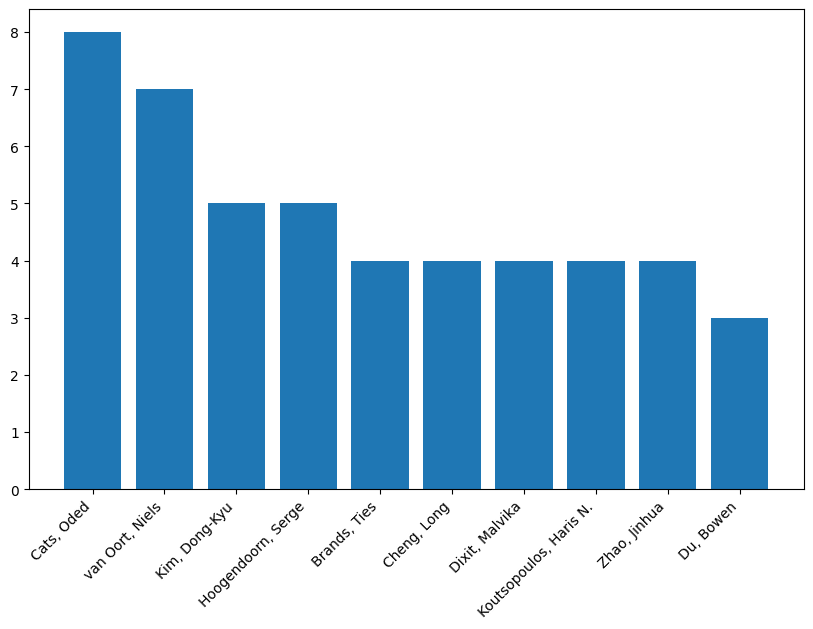

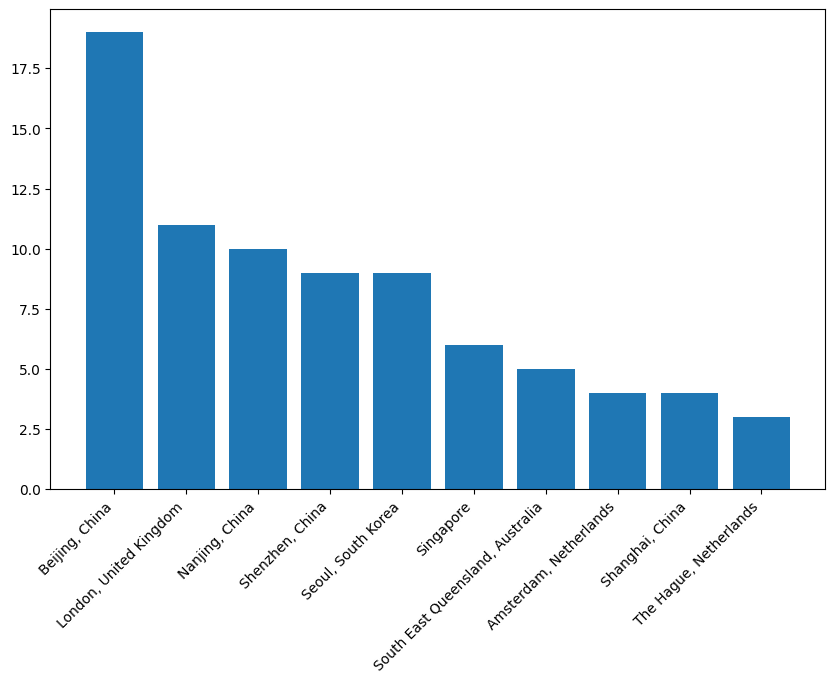

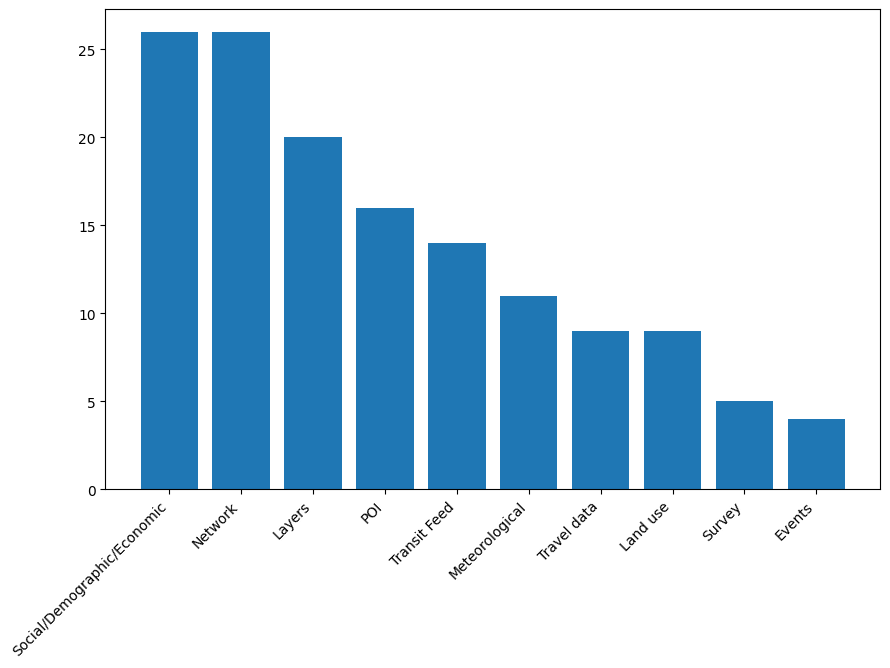

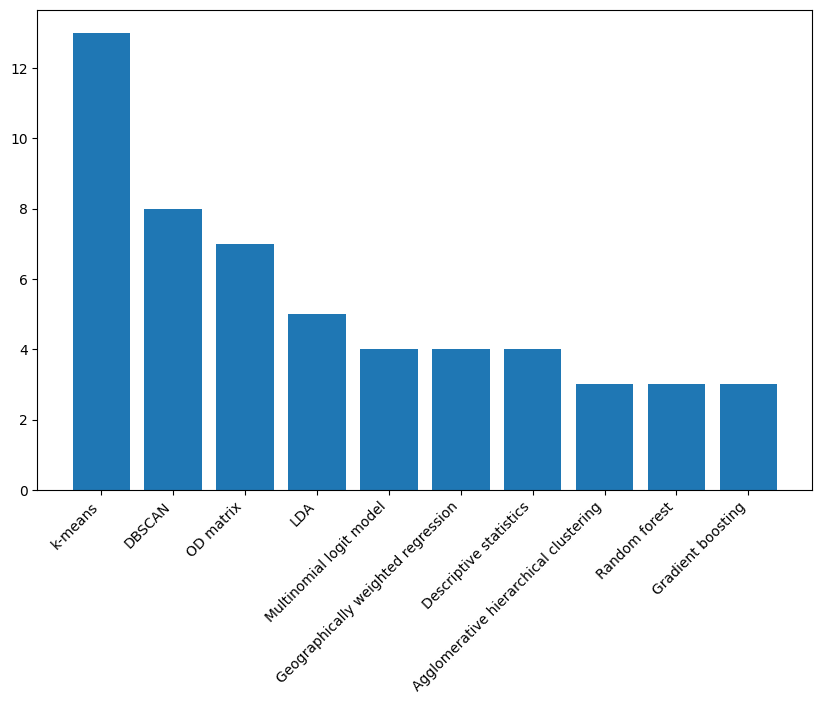

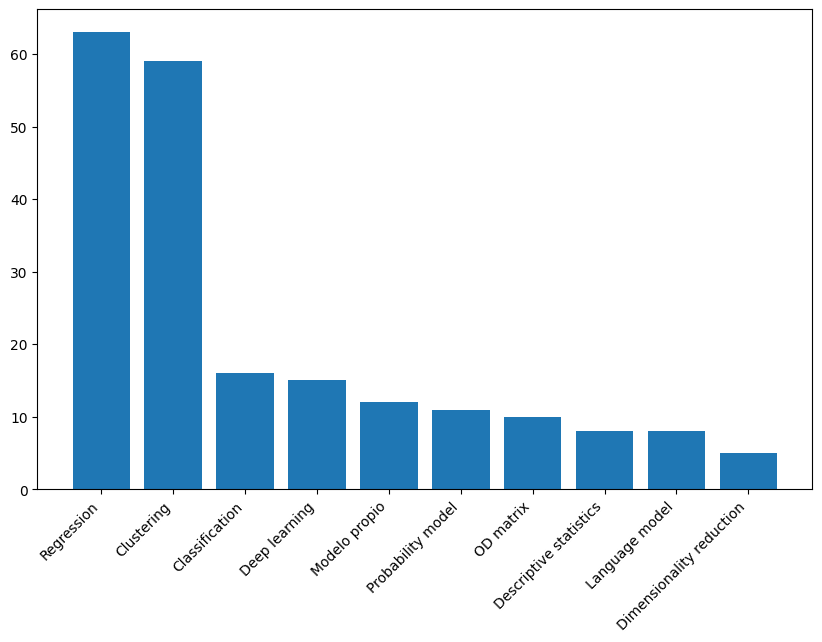

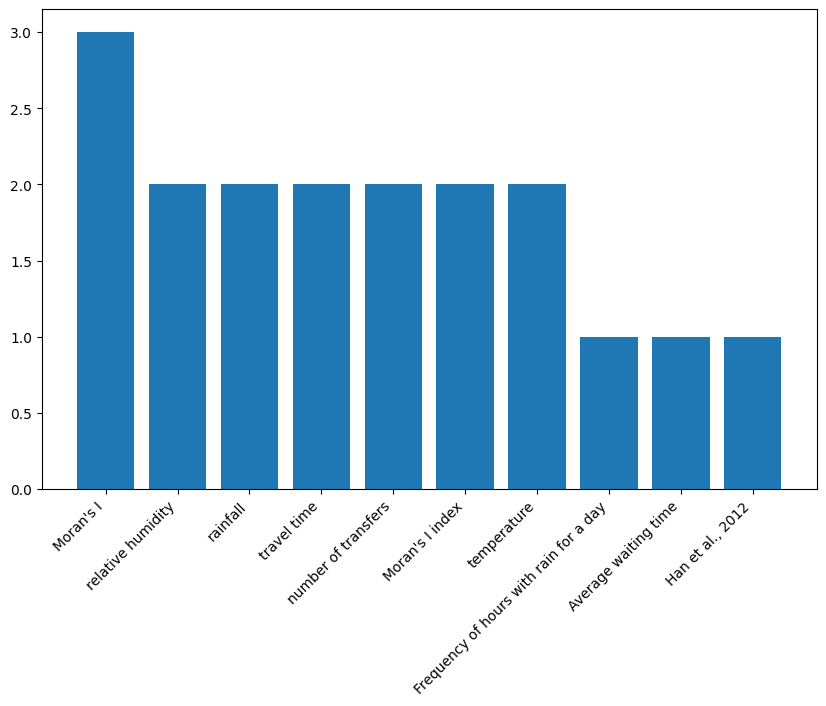

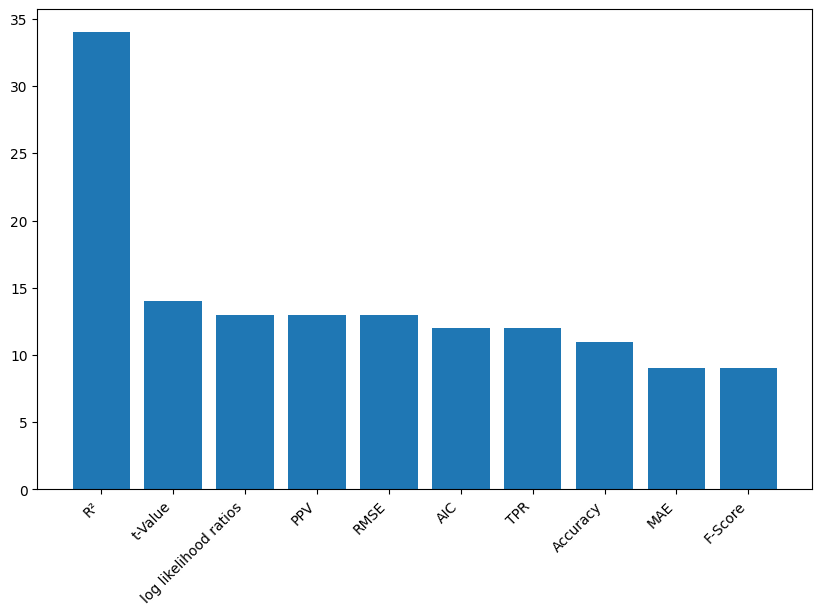

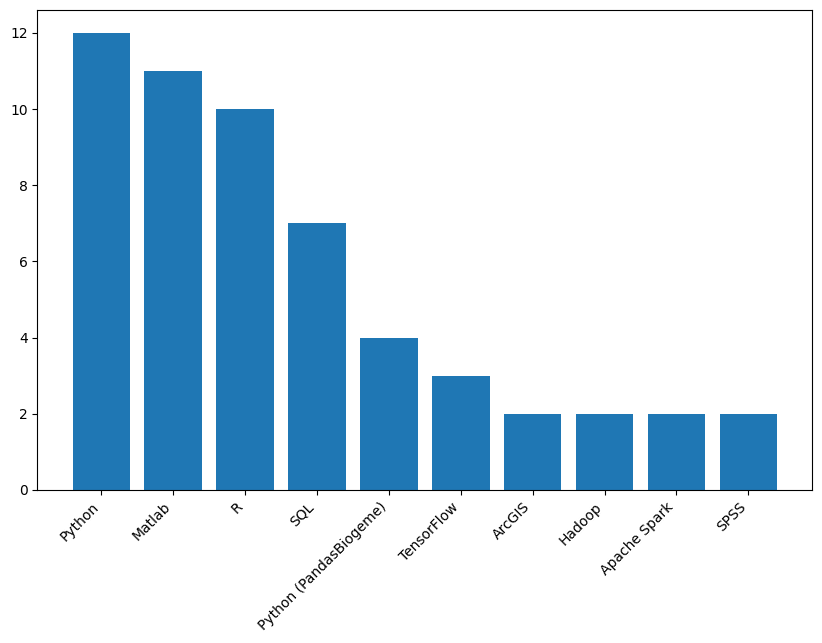

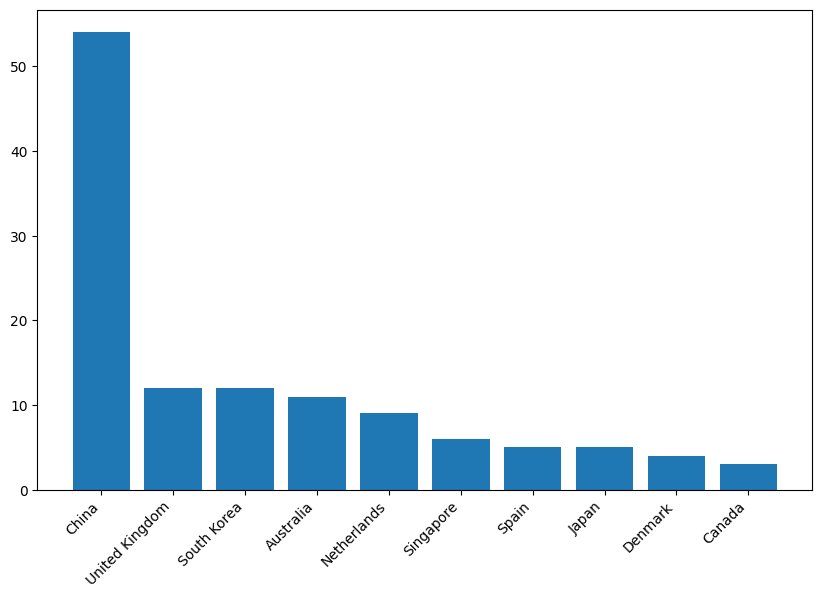

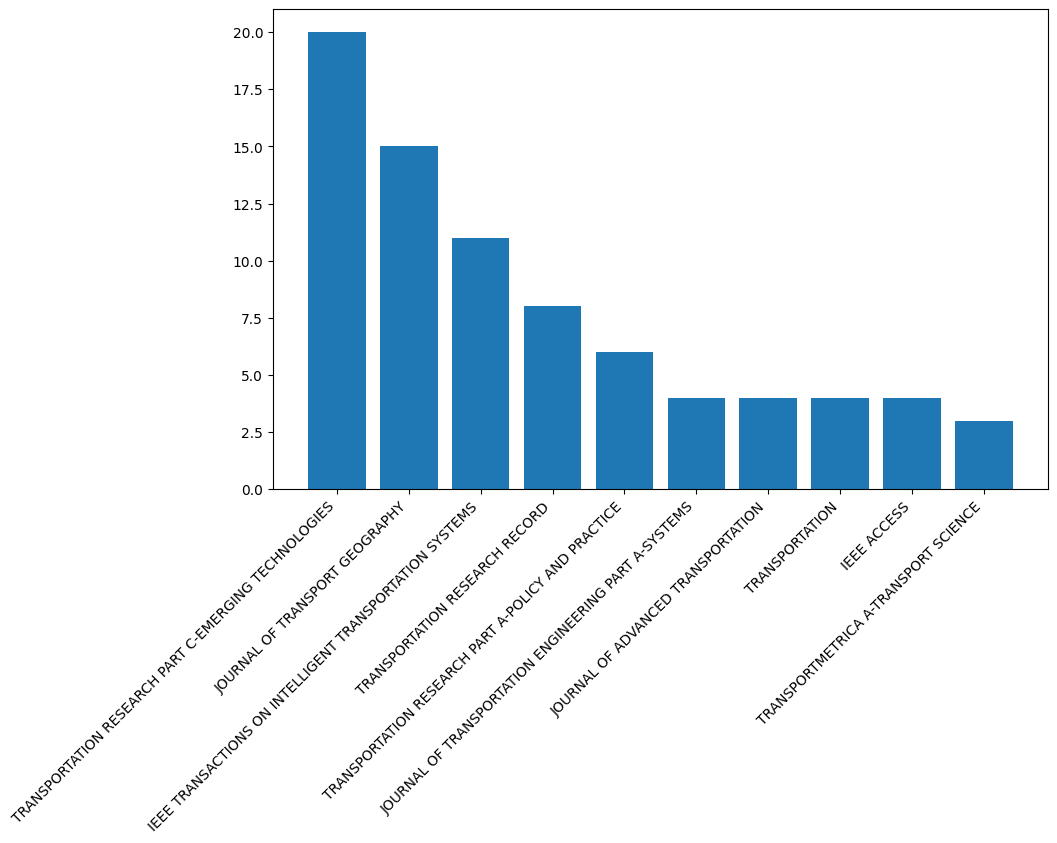

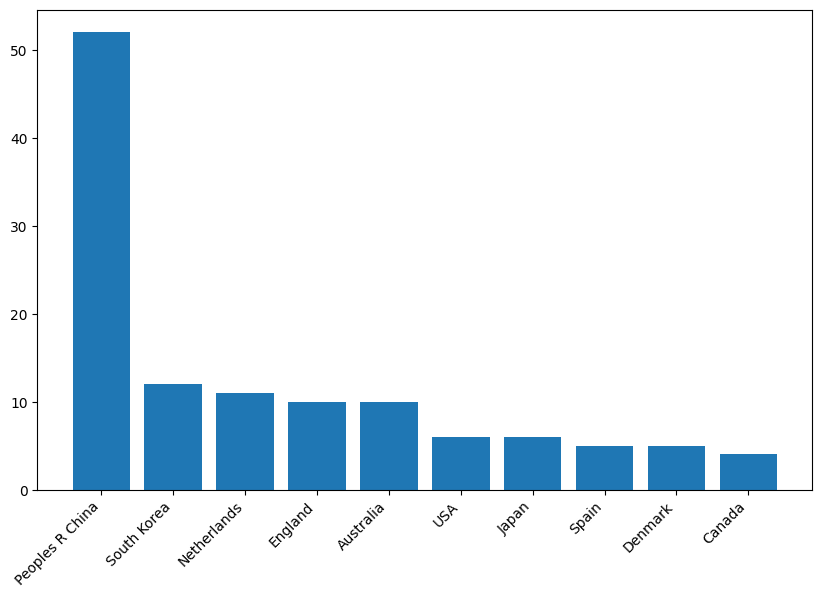

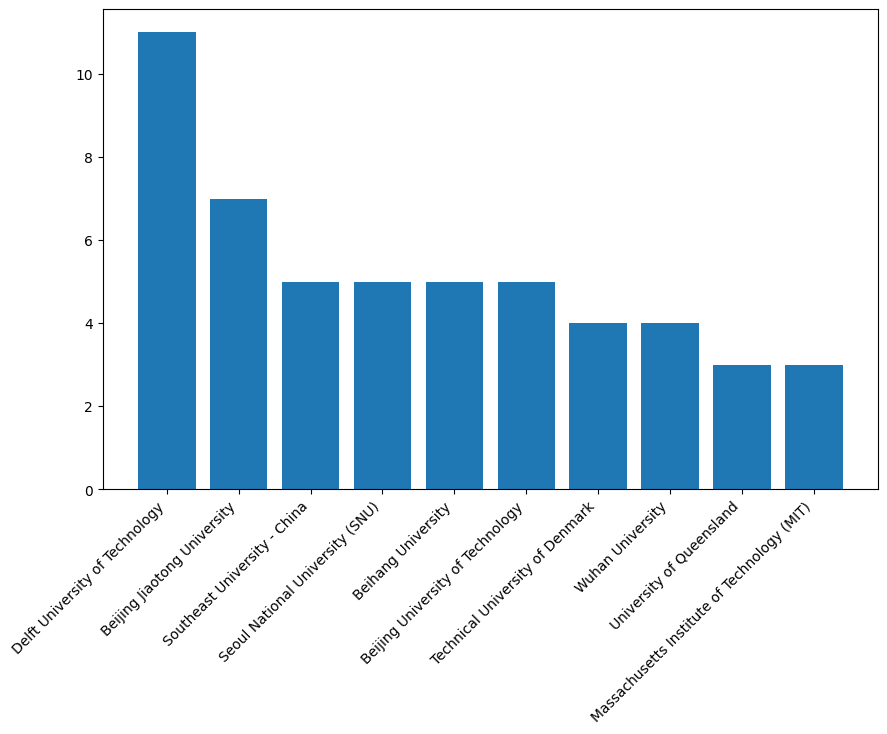

In [19]:
# Crear graficos sencillos
for column in array_columns:
    plot_list = sets_count_dict[column].items()
    plot_list = sorted(plot_list, key=itemgetter(1), reverse=True)
    x, y = zip(*plot_list[:10])

    plt.figure(figsize=(10, 8))
    plt.xticks(rotation=45, ha="right")
    plt.bar(x, y)
    plt.subplots_adjust(bottom=0.28)
    plt.savefig("img/test" + str(column) + ".svg", format="svg")
    plt.show()

In [20]:
# A partir de aquí es codigo para generar los tres tipos de graficos: grafico de barras por año, treemap y Sankey/Alluvial

In [21]:
data = data.explode(["Model", "Model type"], ignore_index=True)

In [22]:
for column in array_columns:
    data = data.explode(column)

In [23]:
columns = array_columns.copy()
columns.append("Publication Year")
columns.append("ID")
columns.append("Analysis type")
columns.append("Year(s)")
columns.append("Days")
columns.append("Total number transactions")

columns_to_plot = columns.copy()
columns_to_plot.remove("ID")
columns_to_plot.remove("Publication Year")
columns_to_plot.remove("Features")
columns_to_plot.remove("Author Full Names")
columns_to_plot.remove("Model")
columns_to_plot.remove("Source Title")
columns_to_plot.remove("Study Area")
columns_to_plot.remove("Year(s)")
columns_to_plot.remove("Days")
columns_to_plot.remove("Total number transactions")
columns_to_plot.remove("Validation metrics")
columns_to_plot.remove("First affiliation")

In [24]:
aggregated_table = (
    data[columns]
    .groupby(["Analysis type", "Model", "Model type"])[["ID"]]
    .nunique()
    .groupby(["Analysis type", "Model type"])[["ID"]]
    .sum()    
    .sort_values(by="ID")
)
fig = px.treemap(
    aggregated_table.reset_index(),
    path=["Analysis type", "Model type"],
    values="ID",
)
fig.update_traces(
    root_color="lightgrey", textinfo="label+value"
)
# fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.write_image("img/treemap_analysis_model.svg")
fig.show()

In [25]:
aggregated_table = (
    data[columns].groupby(["Analysis type"])[["ID"]].nunique().sort_values(by="ID")
)
threshold = aggregated_table.sum().item() * 0.05
other_analysis = aggregated_table.query("ID < @threshold").index.values

aggregated_table = (
    data[columns]
    .groupby(["Model", "Model type"])[["ID"]]
    .nunique()
    .groupby(["Model type"])[["ID"]]
    .sum()
    .sort_values(by="ID")
)
threshold = aggregated_table.sum().item() * 0.025
other_model = aggregated_table.query("ID < @threshold").index.values

aggregated_table = (
    data[columns].groupby(["Other datasets"])[["ID"]].nunique().sort_values(by="ID")
)
threshold = aggregated_table.sum().item() * 0.05
other_datasets = aggregated_table.query("ID < @threshold").index.values

aggregated_table = (
    data[columns].groupby(["Validation metrics"])[["ID"]].nunique().sort_values(by="ID")
)
threshold = aggregated_table.sum().item() * 0.025
other_validation = aggregated_table.query("ID < @threshold").index.values

data["Model type"] = data["Model type"].apply(
    lambda x: "Other" if x in other_model else x
)
data["Analysis type"] = data["Analysis type"].apply(
    lambda x: "Other" if x in other_analysis else x
)
data["Other datasets"] = data["Other datasets"].apply(
    lambda x: "Other" if x in other_datasets else x
)
# data["Validation metrics"] = data["Validation metrics"].apply(
#     lambda x: "Other" if x in other_validation else x
# )

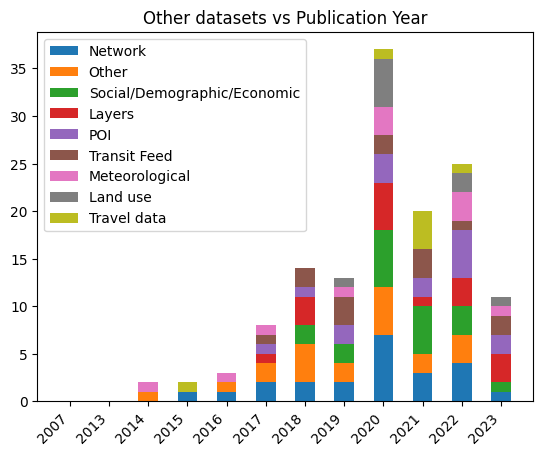

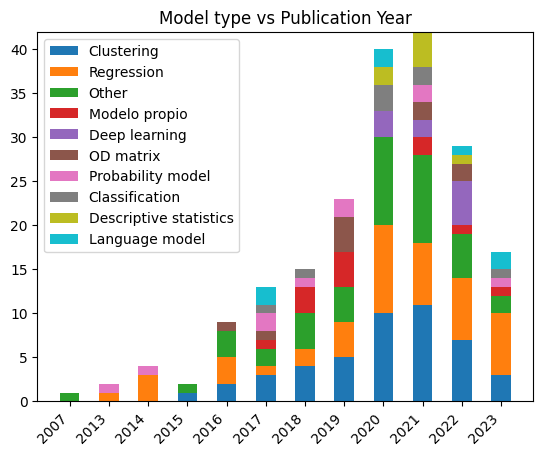

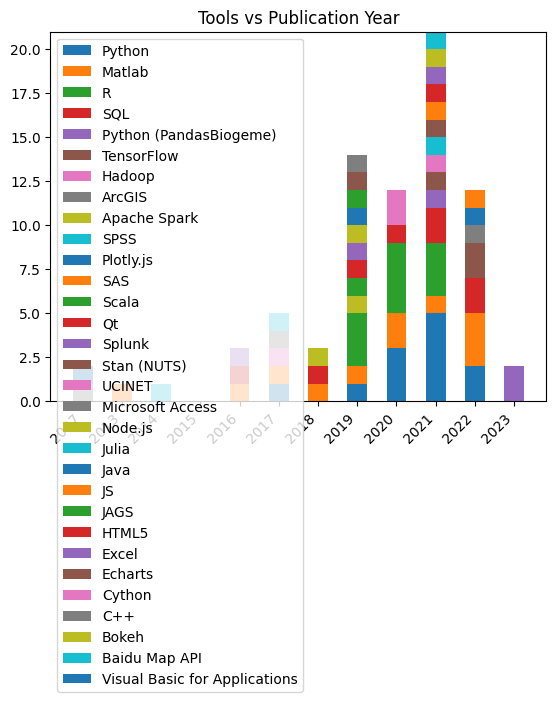

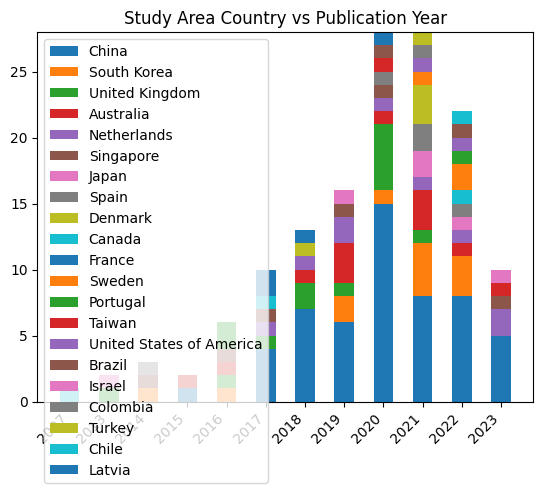

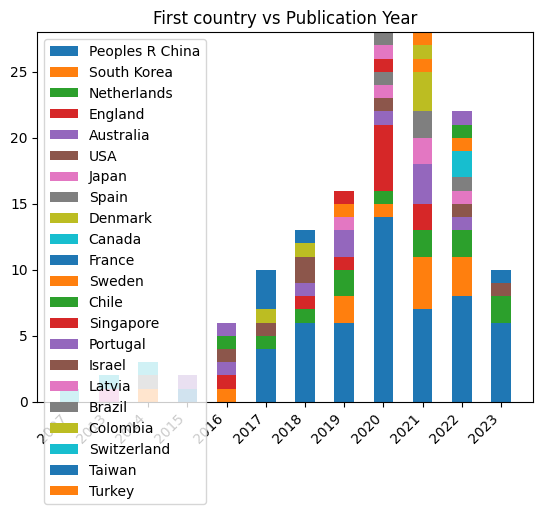

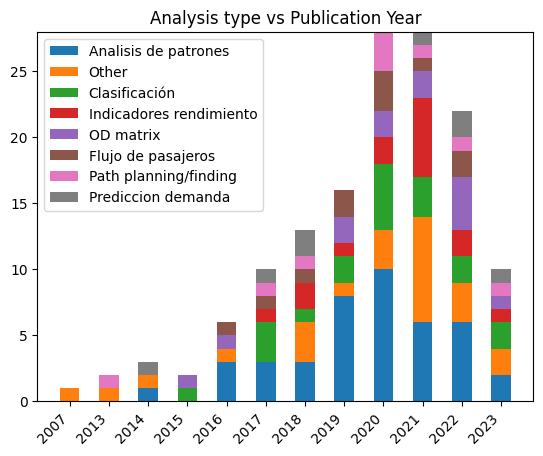

In [26]:
for column_to_plot in columns_to_plot:
    aggregated_table = (
        data[columns]
        .groupby([column_to_plot, "Publication Year"])[["ID"]]
        .nunique()
        .sort_values(by="ID")
    )
    x_array = (
        data[columns]
        .groupby([column_to_plot])[["ID"]]
        .nunique()
        .sort_values(by="ID", ascending=False)
        .index
    )
    years = sorted(list(set(data["Publication Year"])))
    weights_x = dict.fromkeys(x_array, 0)
    for x in weights_x.keys():
        weights_x[x] = []

    for x in x_array:
        for year in years:
            if (x, year) not in aggregated_table.index:
                weights_x[x].append(0)
                continue
            weights_x[x].append(aggregated_table.loc[(x, year)]["ID"])

    fig, ax = plt.subplots()
    bottom = np.zeros(len(years))
    width = 0.5
    for x, weight_count in weights_x.items():
        p = ax.bar(
            list(map(str, years)), weight_count, width=width, label=x, bottom=bottom
        )
        bottom += weight_count

    ax.set_title(column_to_plot + " vs Publication Year")
    ax.legend(loc="upper left")
    plt.xticks(rotation=45, ha="right")
    plt.savefig("img/test_by_year" + str(column_to_plot) + ".svg", format="svg")
    plt.show()

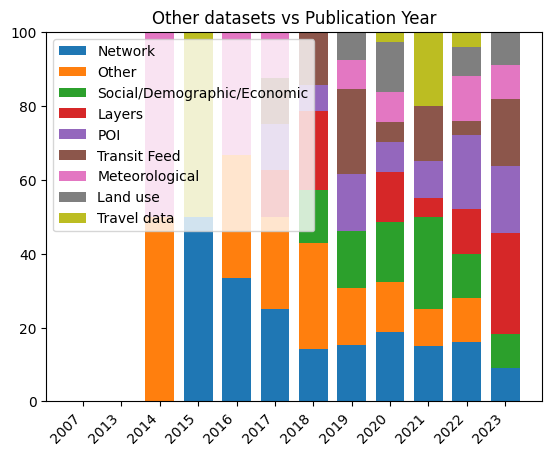

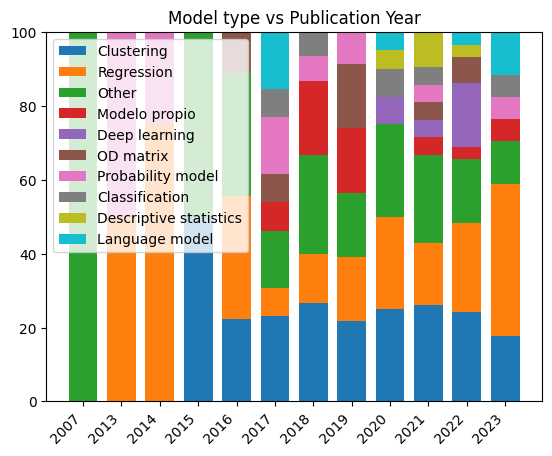

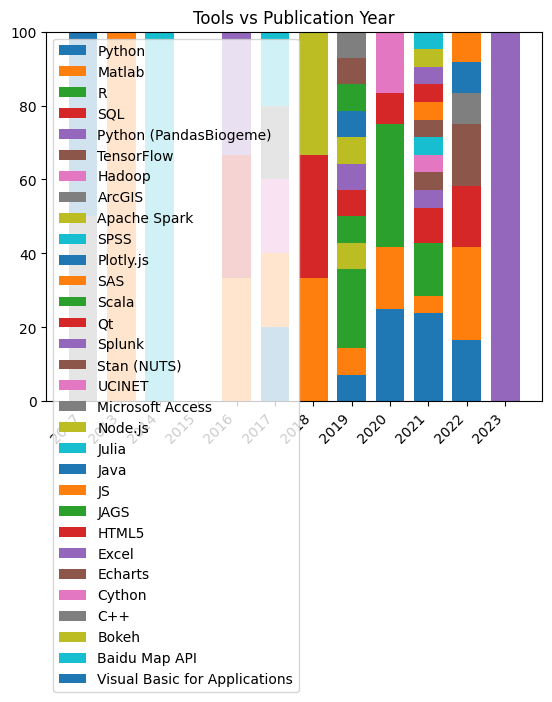

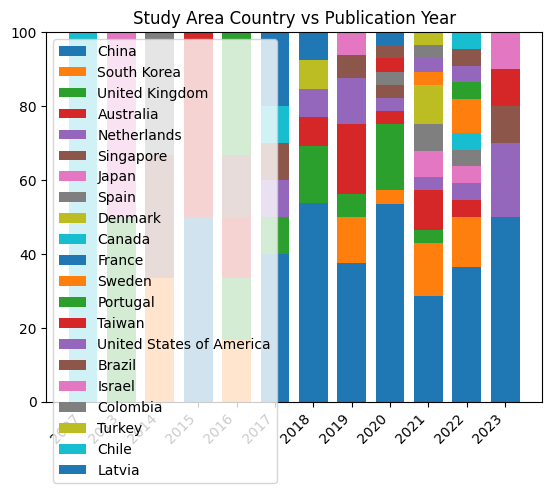

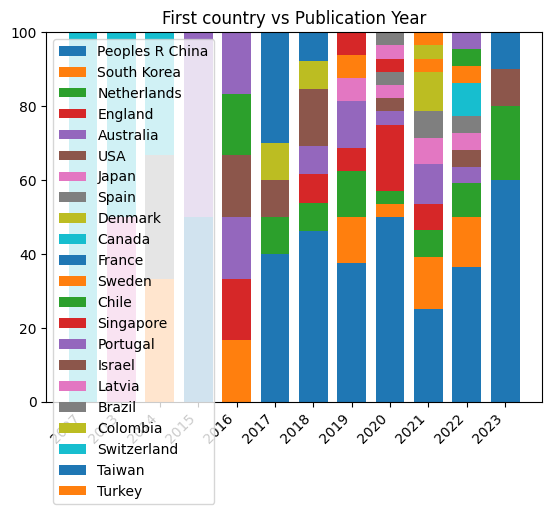

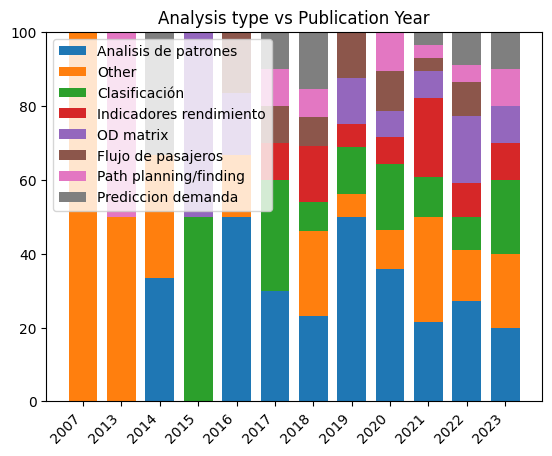

In [27]:
for column_to_plot in columns_to_plot:
    aggregated_table = (
        data[columns]
        .groupby([column_to_plot, "Publication Year"])[["ID"]]
        .nunique()
        .sort_values(by="ID")
    )
    x_array = (
        data[columns]
        .groupby([column_to_plot])[["ID"]]
        .nunique()
        .sort_values(by="ID", ascending=False)
        .index
    )

    years = sorted(list(set(data["Publication Year"])))
    weights_x = dict.fromkeys(x_array, 0)
    for x in weights_x.keys():
        weights_x[x] = []

    for x in x_array:
        for year in years:
            if (x, year) not in aggregated_table.index:
                weights_x[x].append(0)
                continue
            weights_x[x].append(aggregated_table.loc[(x, year)]["ID"])

    sums = [0] * len(weights_x[x])
    for i in range(len(weights_x[x])):
        for x in x_array:
            sums[i] += weights_x[x][i]

    for x in x_array:
        for i, sum in enumerate(sums):
            if sum != 0:
                weights_x[x][i] = weights_x[x][i] / sum * 100

    fig, ax = plt.subplots()
    bottom = np.zeros(len(years))
    width = 0.75
    # p = ax.stackplot(list(map(str, years)), weights_x.values(), labels=weights_x.keys())
    for x, weight_count in weights_x.items():
        p = ax.bar(
            list(map(str, years)), weight_count, width=width, label=x, bottom=bottom
        )
        bottom += weight_count
    ax.set_title(column_to_plot + " vs Publication Year")
    ax.legend(loc="upper left")
    plt.xticks(rotation=45, ha="right")
    plt.savefig("img/test_normalized" + str(column_to_plot) + ".svg", format="svg")
    plt.show()

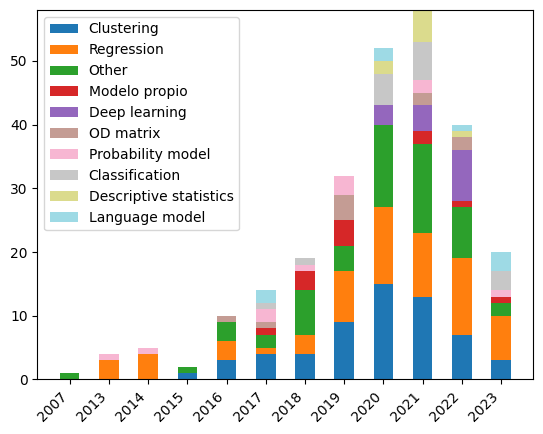

In [28]:
aggregated_table = (
    data[columns]
    .groupby(["Model", "Model type", "Publication Year"])[["ID"]]
    .nunique()
    .groupby(["Model type", "Publication Year"])[["ID"]]
    .sum()
    .sort_values(by="ID")
)
x_array = (
    data[columns]
    .groupby(["Model type"])[["ID"]]
    .nunique()
    .sort_values(by="ID", ascending=False)
    .index
)
hsv = plt.colormaps["hsv"].resampled(len(x_array))
col_map = plt.get_cmap("tab20", len(x_array))
years = sorted(list(set(data["Publication Year"])))
weights_x = dict.fromkeys(x_array, 0)
for x in weights_x.keys():
    weights_x[x] = [0] * len(years)

for x in x_array:
    for i, year in enumerate(years):
        if (x, year) not in aggregated_table.index:
            continue
        weights_x[x][i] += aggregated_table.loc[(x, year)]["ID"]

fig, ax = plt.subplots()
bottom = np.zeros(len(years))
width = 0.5
colors = hsv(range(len(x_array)))
for x, weight_count in weights_x.items():
    p = ax.bar(
        list(map(str, years)),
        weight_count,
        width=width,
        label=x,
        bottom=bottom,
        # color=colors[x_array.get_loc(x)],
        color=col_map.colors[x_array.get_loc(x)],
    )
    bottom += weight_count

ax.set_title("")
ax.legend(loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.savefig("img/test_model_type" + ".svg", format="svg")
plt.show()

In [29]:
# v = {
#     k: [dic[k] for dic in list(sets_count_dict_by_year["Study Area"].values())]
#     for k in list(sets_count_dict_by_year["Study Area"].values())[0]
# }

In [30]:
# aggregated_table = (
#     data[columns]
#     .groupby(["Model", "Model type", "Analysis type"])[["ID"]]
#     .nunique()
#     .groupby(["Analysis type"])[["ID"]]
#     .sum()
#     .sort_values(by="ID")
# )
# threshold = aggregated_table.sum().item() * 0.05
# other_analysis = aggregated_table.query('ID < @threshold').index.values
# aggregated_table = (
#     data[columns]
#     .groupby(["Model", "Model type", "Analysis type"])[["ID"]]
#     .nunique()
#     .groupby(["Model type"])[["ID"]]
#     .sum()
#     .sort_values(by="ID")
# )
# threshold = aggregated_table.sum().item() * 0.025
# other_model = aggregated_table.query('ID < @threshold').index.values

# data["Model type"] = data["Model type"].apply(lambda x: "Other" if x in other_model else x)
# data["Analysis type"] = data["Analysis type"].apply(lambda x: "Other" if x in other_analysis else x)

In [31]:
aggregated_table2 = (
    data[columns]
    .groupby(["Other datasets", "Analysis type"])[["ID"]]
    .nunique()
    .sort_values(by="ID")
).reset_index()

aggregated_table = (
    data[columns]
    .groupby(["Model", "Model type", "Analysis type"])[["ID"]]
    .nunique()
    .groupby(["Model type", "Analysis type"])[["ID"]]
    .sum()
    .sort_values(by="ID")
).reset_index()

label1 = sorted(list(sets_dict["Model type"]))
label1.append("Other")
label2 = sorted(set(data["Analysis type"].tolist()))
label3 = sorted(list(sets_dict["Other datasets"]))
label3.append("Other")


source = []
target = []
value = []

for row in aggregated_table.iterrows():
    source.append(label1.index(row[1]["Model type"]))
    target.append(label2.index(row[1]["Analysis type"]) + len(label1))
    value.append(row[1]["ID"])


for row in aggregated_table2.iterrows():
    source.append(label2.index(row[1]["Analysis type"]) + len(label1))
    target.append(label3.index(row[1]["Other datasets"]) + len(label1) + len(label2))
    value.append(row[1]["ID"])

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=label1 + label2 + label3,
                color="blue",
            ),
            link=dict(
                source=source,  # indices correspond to labels, eg A1, A2, A1, B1, ...
                target=target,
                value=value,
            ),
        )
    ]
)

fig.update_layout(title_text="Basic Sankey Diagram")
fig.write_image("img/models_datasets_sankey.svg")
fig.show()

In [32]:
aggregated_table = (
    data[columns]
    .groupby(["Model", "Model type", "Analysis type"])[["ID"]]
    .nunique()
    .groupby(["Model type", "Analysis type"])[["ID"]]
    .sum()
    .sort_values(by="ID")
).reset_index()

label1 = sorted(list(sets_dict["Model type"]))
label1.append("Other")
label2 = sorted(set(data["Analysis type"].tolist()))

source = []
target = []
value = []


for row in aggregated_table.iterrows():
    source.append(label1.index(row[1]["Model type"]))
    target.append(label2.index(row[1]["Analysis type"]) + len(label1))
    value.append(row[1]["ID"])

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=label1 + label2,
                color="blue",
            ),
            link=dict(
                source=source,  # indices correspond to labels, eg A1, A2, A1, B1, ...
                target=target,
                value=value,
            ),
        )
    ]
)

fig.update_layout(title_text="Basic Sankey Diagram")
fig.write_image("img/models_sankey.svg")
fig.show()

In [33]:
aggregated_table = (
    data[columns]
    .groupby(["Analysis type", "Validation metrics"])[["ID"]]
    .nunique()
    .sort_values(by="ID")
)
fig = px.treemap(
    aggregated_table.reset_index(),
    path=["Analysis type", "Validation metrics"],
    values="ID",
)
fig.update_traces(
    root_color="lightgrey", textinfo="label+value"
)
# fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.write_image("img/treemap_analysys_validation.svg")
fig.show()


In [34]:
df = px.data.gapminder().query("year==2007")
df = df[["country", "iso_alpha"]]
study_country = pd.DataFrame(columns=["country", "iso_alpha", "Number of articles"])
for country in sets_count_dict["Study Area Country"].keys():
    if len(df.query("country == @country")["iso_alpha"].values) != 0:
        study_country = pd.concat(
            [
                study_country,
                pd.Series(
                    {
                        "country": country,
                        "iso_alpha": df.query("country == @country")[
                            "iso_alpha"
                        ].values[0],
                        "Number of articles": sets_count_dict["Study Area Country"][
                            country
                        ],
                    }
                )
                .to_frame()
                .T,
            ],
            ignore_index=True,
        )

study_country["Number of articles"] = pd.to_numeric(study_country["Number of articles"])
incorrect_study_country = pd.DataFrame(
    [
        {
            "country": "Latvia",
            "iso_alpha": "LVA",
            "Number of articles": sets_count_dict["Study Area Country"]["Latvia"],
        },
        {
            "country": "United States of America",
            "iso_alpha": "USA",
            "Number of articles": sets_count_dict["Study Area Country"][
                "United States of America"
            ],
        },
        {
            "country": "South Korea",
            "iso_alpha": "KOR",
            "Number of articles": sets_count_dict["Study Area Country"]["South Korea"],
        },
    ]
)
study_country = pd.concat([study_country, incorrect_study_country], ignore_index=True)

fig = px.choropleth(
    study_country,
    locations="iso_alpha",
    color="Number of articles",  # lifeExp is a column of gapminder
    hover_name="country",  # column to add to hover information
    color_continuous_scale=px.colors.sequential.Plasma_r,
)
fig.write_image("img/study_map.svg")
fig.show()

In [ ]:
df = px.data.gapminder().query("year==2007")
df = df[["country", "iso_alpha"]]
study_country = pd.DataFrame(columns=["country", "iso_alpha", "Number of articles"])
for country in sets_count_dict["First country"].keys():
    if len(df.query("country == @country")["iso_alpha"].values) != 0:
        study_country = pd.concat(
            [
                study_country,
                pd.Series(
                    {
                        "country": country,
                        "iso_alpha": df.query("country == @country")[
                            "iso_alpha"
                        ].values[0],
                        "Number of articles": sets_count_dict["First country"][country],
                    }
                )
                .to_frame()
                .T,
            ],
            ignore_index=True,
        )

study_country["Number of articles"] = pd.to_numeric(study_country["Number of articles"])
incorrect_study_country = pd.DataFrame(
    [
        {
            "country": "Latvia",
            "iso_alpha": "LVA",
            "Number of articles": sets_count_dict["First country"]["Latvia"],
        },
        {
            "country": "United States of America",
            "iso_alpha": "USA",
            "Number of articles": sets_count_dict["First country"]["USA"],
        },
        {
            "country": "South Korea",
            "iso_alpha": "KOR",
            "Number of articles": sets_count_dict["First country"]["South Korea"],
        },
        {
            "country": "China",
            "iso_alpha": "CHN",
            "Number of articles": sets_count_dict["First country"]["Peoples R China"],
        },
        {
            "country": "United Kingdom",
            "iso_alpha": "GBR",
            "Number of articles": sets_count_dict["First country"]["England"],
        },
    ]
)
study_country = pd.concat([study_country, incorrect_study_country], ignore_index=True)
fig = px.choropleth(
    study_country,
    locations="iso_alpha",
    color="Number of articles",  # lifeExp is a column of gapminder
    hover_name="country",  # column to add to hover information
    color_continuous_scale=px.colors.sequential.Plasma_r,
)
fig.write_image("img/authors_map.svg")
fig.show()

In [ ]:
aggregated_table = (
    data[columns].groupby(["Publication Year"])[["ID"]].nunique().sort_values(by="Publication Year")
).reset_index()
aggregated_table

x = list(map(str, aggregated_table["Publication Year"]))
y = aggregated_table["ID"]

plt.figure(figsize=(10, 8))
plt.xticks(rotation=45, ha="right")
plt.bar(x, y)
plt.subplots_adjust(bottom=0.28)
plt.savefig("img/test" + "Years" + ".svg", format="svg")
plt.show()

In [37]:
biblio.columns = [column.replace(" ", "_") for column in biblio.columns]

In [38]:
df = px.data.gapminder().query("year==2007")
lat = []
lon = []
affiliations = []
values = []
for affiliation in sets_count_dict["First affiliation"].keys():
    affiliations.append(affiliation)
    lat.append(biblio.query("First_affiliation == @affiliation")["First_affiliation_coordinates"].values[0][0])
    lon.append(biblio.query("First_affiliation == @affiliation")["First_affiliation_coordinates"].values[0][1])
    values.append(sets_count_dict["First affiliation"][affiliation])

df = pd.DataFrame({"affiliation":affiliations,
                  "lat":lat,
                  "lon":lon,
                  "values":values})
fig = px.scatter_geo(df, lat="lat", lon="lon",
                     hover_name="affiliation", size="values",
                     projection="natural earth", color="values")
fig.write_image("img/affiliation_map.svg")
fig.show()

In [39]:
df = px.data.gapminder().query("year==2007")
lat = []
lon = []
cities = []
values = []
for city in sets_count_dict["Study Area"].keys():
    cities.append(city)
    if city == "South-West Scania, Sweden":
        coordinates = ox.geocode("Scania, Sweden")
    elif city == "Greater Toronto and Hamilton Area, Canada":
        coordinates = ox.geocode("Toronto, Canada")
    elif city == "Kansai Area, Japan":
        coordinates = ox.geocode("関西地方")
    elif city == "Greater Copenhagen area, Denmark":
        coordinates = ox.geocode("Copenhague, Denmark")
    elif city == "Eastern Denmark, Denmark":
        coordinates = ox.geocode("Denmark")
    else:
        coordinates = ox.geocode(city)
    lat.append(coordinates[0])
    lon.append(coordinates[1])
    values.append(sets_count_dict["Study Area"][city])

df = pd.DataFrame({"cities":cities,
                  "lat":lat,
                  "lon":lon,
                  "values":values})
fig = px.scatter_geo(df, lat="lat", lon="lon",
                     hover_name="cities", size="values",
                     projection="natural earth", color="values")
fig.write_image("img/study_area_map.svg")
fig.show()

In [40]:
data = data.explode("Year(s)")

In [41]:
aggregated_table = (
    data[columns]
    .groupby(["Total number transactions", "Days", "Year(s)"])[["ID"]]
    .nunique()
    .groupby(["Total number transactions", "Days"])[["ID"]]
    .sum()
    .sort_values(by="Total number transactions")
).reset_index()

# aggregated_table2 = (
#     data[columns]
#     .groupby(["Total number transactions", "Days", "Year(s)"])[["ID"]]
#     .nunique()
#     .groupby(["Days","Year(s)"])[["ID"]]
#     .sum()
#     .sort_values(by="ID")
# ).reset_index()

label1 = sorted(set(data["Total number transactions"].tolist()))
label2 = sorted(set(data["Days"].tolist()))
label3 = sorted(set(data["Year(s)"].tolist()))

source = []
target = []
value = []

for row in aggregated_table.iterrows():
    source.append(label1.index(row[1]["Total number transactions"]))
    target.append(label2.index(row[1]["Days"]) + len(label1))
    value.append(row[1]["ID"])


# for row in aggregated_table2.iterrows():
#     source.append(label2.index(row[1]["Days"]) + len(label1))
#     target.append(label3.index(row[1]["Year(s)"]) + len(label1) + len(label2))
#     value.append(row[1]["ID"])

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=label1 + label2 + label3,
                color="blue",
            ),
            link=dict(
                source=source,  # indices correspond to labels, eg A1, A2, A1, B1, ...
                target=target,
                value=value,
            ),
        )
    ]
)

fig.update_layout(title_text="Basic Sankey Diagram")
fig.write_image("img/datasets_sankey.svg")
fig.show()

In [42]:
aggregated_table = (
    data[columns]
    .groupby(["Total number transactions", "Days", "Year(s)"])[["ID"]]
    .nunique()
    .groupby(["Total number transactions", "Days"])[["ID"]]
    .sum()
    .sort_values(by="Total number transactions")
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{llr}
\toprule
Total number transactions & Days & ID \\
\midrule
(2, 3] & Months & 1 \\
(4, 5] & Months & 1 \\
(5, 6] & Days & 6 \\
(5, 6] & Months & 5 \\
(5, 6] & Weeks & 2 \\
(5, 6] & Year(s) & 3 \\
(6, 7] & Days & 8 \\
(6, 7] & Months & 25 \\
(6, 7] & NA & 1 \\
(6, 7] & Weeks & 11 \\
(6, 7] & Year(s) & 4 \\
(7, 8] & Year(s) & 4 \\
(7, 8] & Weeks & 5 \\
(7, 8] & Days & 9 \\
(7, 8] & Months & 17 \\
(8, 9] & Days & 4 \\
(8, 9] & Months & 21 \\
(8, 9] & Weeks & 10 \\
(8, 9] & Year(s) & 9 \\
(9, 10] & Months & 10 \\
(9, 10] & Year(s) & 9 \\
NA & Months & 7 \\
NA & Days & 2 \\
NA & Weeks & 2 \\
\bottomrule
\end{tabular}



In [43]:
aggregated_table = (
    data[columns]
    .groupby(["Total number transactions", "Days", "Year(s)"])[["ID"]]
    .nunique()
    .groupby(["Total number transactions"])[["ID"]]
    .sum()
    .sort_values(by="Total number transactions")
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Total number transactions & ID \\
\midrule
(2, 3] & 1 \\
(4, 5] & 1 \\
(5, 6] & 16 \\
(6, 7] & 49 \\
(7, 8] & 35 \\
(8, 9] & 44 \\
(9, 10] & 19 \\
NA & 11 \\
\bottomrule
\end{tabular}



In [44]:
aggregated_table = (
    data[columns]
    .groupby(["Total number transactions", "Days", "Year(s)"])[["ID"]]
    .nunique()
    .groupby(["Days"])[["ID"]]
    .sum()
    .sort_values(by="Days")
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{lr}
\toprule
Days & ID \\
\midrule
Days & 29 \\
Months & 87 \\
NA & 1 \\
Weeks & 30 \\
Year(s) & 29 \\
\bottomrule
\end{tabular}



In [45]:
aggregated_table = (
    data[columns]
    .groupby(["Total number transactions", "Days", "Year(s)"])[["ID"]]
    .nunique()
    .groupby(["Year(s)"])[["ID"]]
    .sum()
    .sort_values(by="Year(s)")
).reset_index()
print(aggregated_table.to_latex(index=False))

\begin{tabular}{rr}
\toprule
Year(s) & ID \\
\midrule
2003 & 1 \\
2005 & 1 \\
2006 & 1 \\
2007 & 1 \\
2008 & 2 \\
2009 & 1 \\
2010 & 4 \\
2011 & 6 \\
2012 & 10 \\
2013 & 21 \\
2014 & 12 \\
2015 & 24 \\
2016 & 15 \\
2017 & 27 \\
2018 & 24 \\
2019 & 19 \\
2020 & 7 \\
\bottomrule
\end{tabular}

